In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
data = pd.read_csv(url)
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


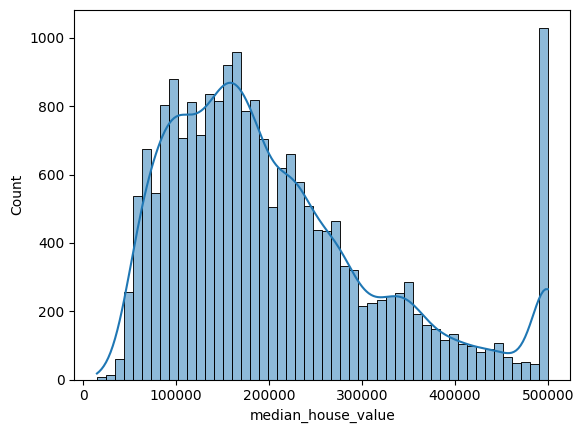

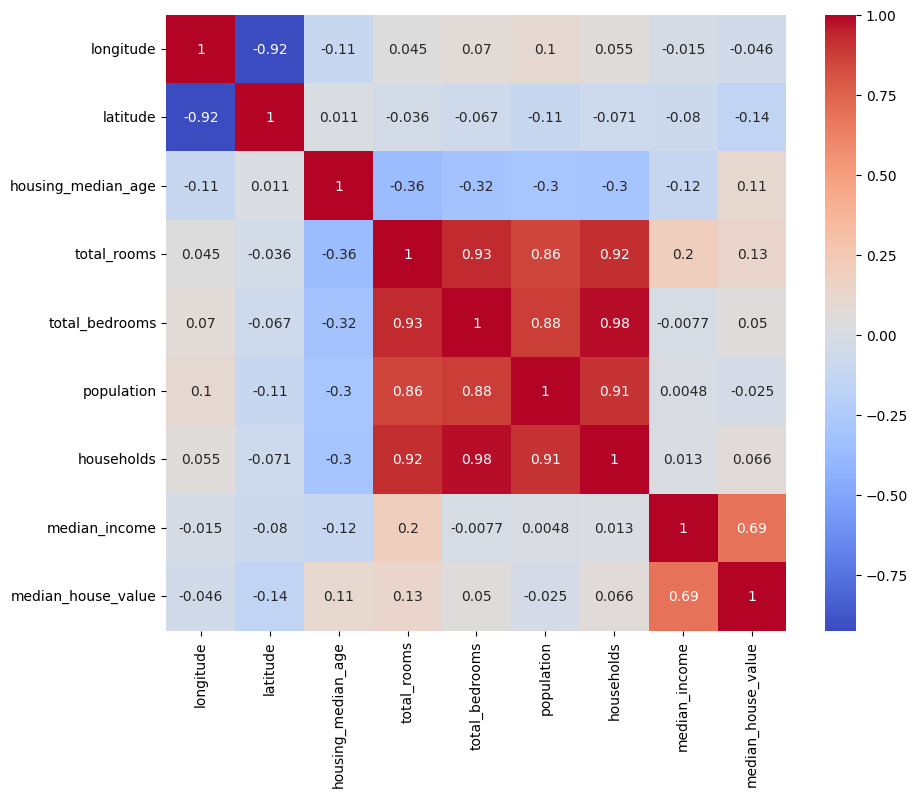

In [3]:
data.info()
data.describe()

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data["median_house_value"], bins=50, kde=True)
plt.show()

corr = data.select_dtypes(include=["int64", "float64"]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()



In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Baseline: Linear Regression
lin_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])
lin_reg.fit(X_train, y_train)
preds_lin = lin_reg.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, preds_lin))
print("Linear Regression RMSE:", rmse_lin)

# RandomForest
rf_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_reg.fit(X_train, y_train)
preds_rf = rf_reg.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))
print("RandomForest RMSE:", rmse_rf)

# XGBoost
xgb_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1))
])
xgb_reg.fit(X_train, y_train)
preds_xgb = xgb_reg.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
print("XGBoost RMSE:", rmse_xgb)

# LightGBM
lgb_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=-1, random_state=42, n_jobs=-1))
])
lgb_reg.fit(X_train, y_train)
preds_lgb = lgb_reg.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))
print("LightGBM RMSE:", rmse_lgb)


Linear Regression RMSE: 70059.19333925014
RandomForest RMSE: 48941.70034309343
XGBoost RMSE: 46386.17567295473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
LightGBM RMSE: 45400.27317882064


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


               Model          RMSE
0  Linear Regression  70059.193339
1       RandomForest  48941.700343
2            XGBoost  46386.175673
3           LightGBM  45400.273179


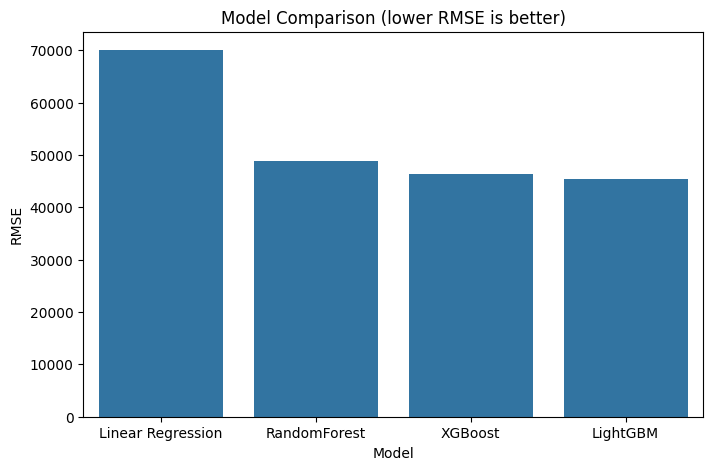

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame({
    "Model": ["Linear Regression", "RandomForest", "XGBoost", "LightGBM"],
    "RMSE": [rmse_lin, rmse_rf, rmse_xgb, rmse_lgb]
})

print(results)

plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="RMSE")
plt.title("Model Comparison (lower RMSE is better)")
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10]
}

search = RandomizedSearchCV(
    rf_reg, param_grid, n_iter=5, scoring="neg_root_mean_squared_error",
    cv=3, random_state=42, n_jobs=-1
)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best RMSE:", -search.best_score_)


Best params: {'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__max_depth': None}
Best RMSE: 50354.360624446206
